Trying to filter small populatino fragments to get a measure of ILS in windows.

In [2]:
%run ../scripts/notebook_settings_lean.py
from horizonplot import horizonplot

In [30]:
# Functions to generate the painting dataframes and identify proportion of short fragments.

def length_to_windows_ils(length_df, window_size=100000, ils_filter=2000):
    pops = sorted(length_df["pop"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    length_df = length_df.loc[length_df.paint_length < ils_filter]
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.paint_length)//window_size
            if x == 0:
                overall_dict[row["pop"]][i] += int(row.paint_length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["pop"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["pop"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["pop"]][i+x] += int(row.paint_length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

def create_paint_df_lengths(paintfile, idfile):
    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index*2+1] = row["pop"]
        map_dict[row.ID_index*2+2] = row["pop"]

    df_l = []
    f = open(paintfile, "r")
    ad_lines = f.readlines()
    ind = ""
    hap = ""
    for p_num in range(1, len(ad_lines)):
        l = ad_lines[p_num].strip().split(" ")
        if l[0] == "HAP":
            ind = l[2]
            if hap == 1:
                hap = 2
            else:
                hap = 1
        else:
            paint_line = l[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            spot_df["individual"] = ind
            spot_df["haplotype"] = hap
            df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

In [5]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"
chrom_list = ["X"] # ["8", "X"] # ["X"]
window_length = 100000
df_l = []
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique())[1:]:
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_8_cluster_large/{}_chr{}_8_cluster_large/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        df_l.append(length_df)
df = pd.concat(df_l)

anubis_tanzania
cyno_central
cyno_western
hamadryas
kindae
papio
ursinus


In [24]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"
chrom_list = ["X"] # ["8", "X"] # ["X"]
os.makedirs("../steps/paint_summary/", exist_ok=True)
#df.to_csv("../steps/paint_summary/paint_lengths.txt")
df = pd.read_csv("../steps/paint_summary/paint_lengths.txt")
df = df.iloc[:,1:]

In [25]:
df.paint_length.mean()

24713.001834235412

In [31]:
window_length = 100000
ils_length = df.paint_length.mean()
ils_d = {}
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique())[1:]:
        ils_l = []
        print(population)
        for ind in idfile.loc[(idfile["pop"] == population) & (idfile.inclusion == 1)].PGDP_ID:
            name = population+"_chr"+chrom+"_8_cluster_"+ind+"_ils.txt"
            window_df = length_to_windows_ils(df.loc[(df.individual==ind)], window_size=window_length, ils_filter=ils_length)
            window_df["PGDP_ID"] = ind
            ils_l.append(window_df)
        ils_df = pd.concat(ils_l)
        ils_d[population] = ils_df

anubis_tanzania
cyno_central
cyno_western
hamadryas
kindae
papio
ursinus


In [32]:
for population in ils_d:
    ils_d[population].to_csv("../steps/paint_summary/ils_df_{}.txt".format(population), index=False)

In [33]:
ils_d["anubis_tanzania"]

,windows,anubis_ethiopia,cyno_central,cyno_western,hamadryas,kindae,papio,ursinus,PGDP_ID
0,2500022,3477.0,152198.0,337372.0,0.0,0.0,69015.0,45818.0,PD_0199
1,2600022,0.0,0.0,0.0,0.0,0.0,57502.0,0.0,PD_0199
2,2700022,30188.0,0.0,4434.0,0.0,0.0,0.0,0.0,PD_0199
3,2800022,46510.0,1810.0,138484.0,388738.0,65033.0,0.0,0.0,PD_0199
4,2900022,79539.0,0.0,38136.0,11102.0,117.0,119983.0,0.0,PD_0199
...,...,...,...,...,...,...,...,...,...
1407,143200022,10718.0,0.0,0.0,0.0,0.0,4109.0,0.0,PD_0686
1408,143300022,39235.0,0.0,0.0,10372.0,0.0,0.0,0.0,PD_0686
1409,143400022,13029.0,6207.0,0.0,12743.0,916.0,578.0,0.0,PD_0686
1410,143500022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PD_0686


Horizonplot

In [34]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
    else:
        mapping[row.PGDP_ID] = row.Origin

In [35]:
pop_inv = "anubis_tanzania"
ils_df = ils_d[pop_inv]
ils_df["pop"] = ils_df["PGDP_ID"].map(mapping)
ils_df["start"] = ils_df["windows"]
ils_df["chrom"] = "chrX"
mean_ils = ils_df.iloc[:,1:8].sum(axis=1).mean()
ils_df["ils"] = (ils_df.iloc[:,1:8].sum(axis=1))

In [36]:
ils_df

,windows,anubis_ethiopia,cyno_central,cyno_western,hamadryas,kindae,papio,ursinus,PGDP_ID,pop,start,chrom,ils
0,2500022,3477.0,152198.0,337372.0,0.0,0.0,69015.0,45818.0,PD_0199,"Serengeti, Tanzania",2500022,chrX,607880.0
1,2600022,0.0,0.0,0.0,0.0,0.0,57502.0,0.0,PD_0199,"Serengeti, Tanzania",2600022,chrX,57502.0
2,2700022,30188.0,0.0,4434.0,0.0,0.0,0.0,0.0,PD_0199,"Serengeti, Tanzania",2700022,chrX,34622.0
3,2800022,46510.0,1810.0,138484.0,388738.0,65033.0,0.0,0.0,PD_0199,"Serengeti, Tanzania",2800022,chrX,640575.0
4,2900022,79539.0,0.0,38136.0,11102.0,117.0,119983.0,0.0,PD_0199,"Serengeti, Tanzania",2900022,chrX,248877.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,143200022,10718.0,0.0,0.0,0.0,0.0,4109.0,0.0,PD_0686,"Lake Manyara, Tanzania",143200022,chrX,14827.0
1408,143300022,39235.0,0.0,0.0,10372.0,0.0,0.0,0.0,PD_0686,"Lake Manyara, Tanzania",143300022,chrX,49607.0
1409,143400022,13029.0,6207.0,0.0,12743.0,916.0,578.0,0.0,PD_0686,"Lake Manyara, Tanzania",143400022,chrX,33473.0
1410,143500022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PD_0686,"Lake Manyara, Tanzania",143500022,chrX,0.0


In [37]:
ils_df.ils.sum()

16893544731.0

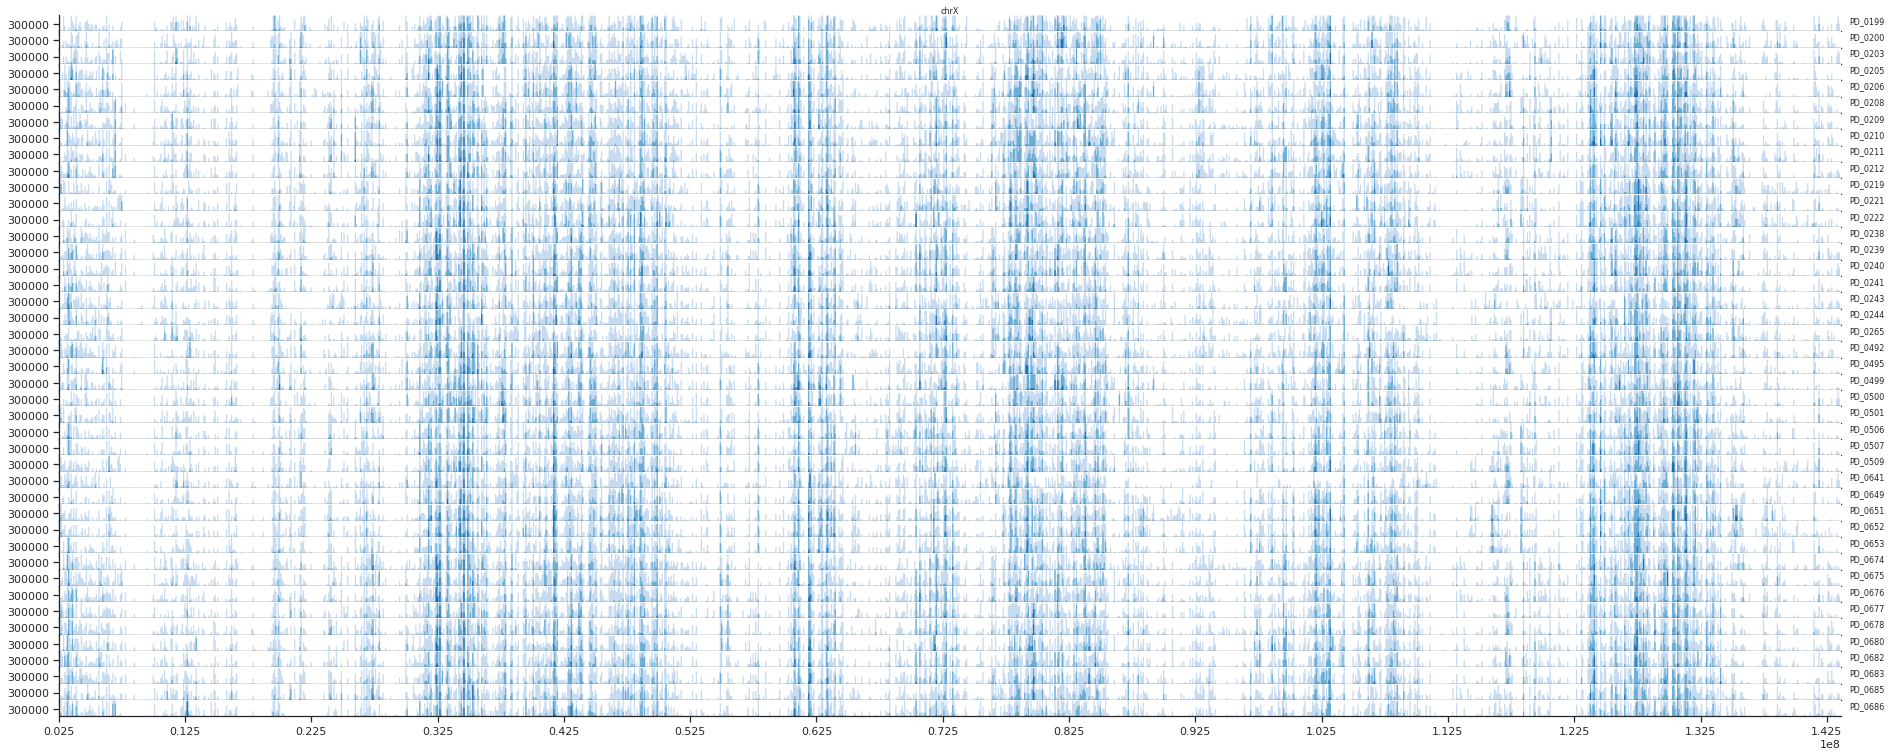

In [38]:
fig = horizonplot(ils_df, 'ils', width=2, col='chrom', row='PGDP_ID', size=0.3, aspect=100)

In [39]:
pop_inv = "cyno_central"
ils_df = ils_d[pop_inv]
ils_df["pop"] = ils_df["PGDP_ID"].map(mapping)
ils_df["start"] = ils_df["windows"]
ils_df["chrom"] = "chrX"
mean_ils = ils_df.iloc[:,1:8].sum(axis=1).mean()
ils_df["ils"] = (ils_df.iloc[:,1:8].sum(axis=1))

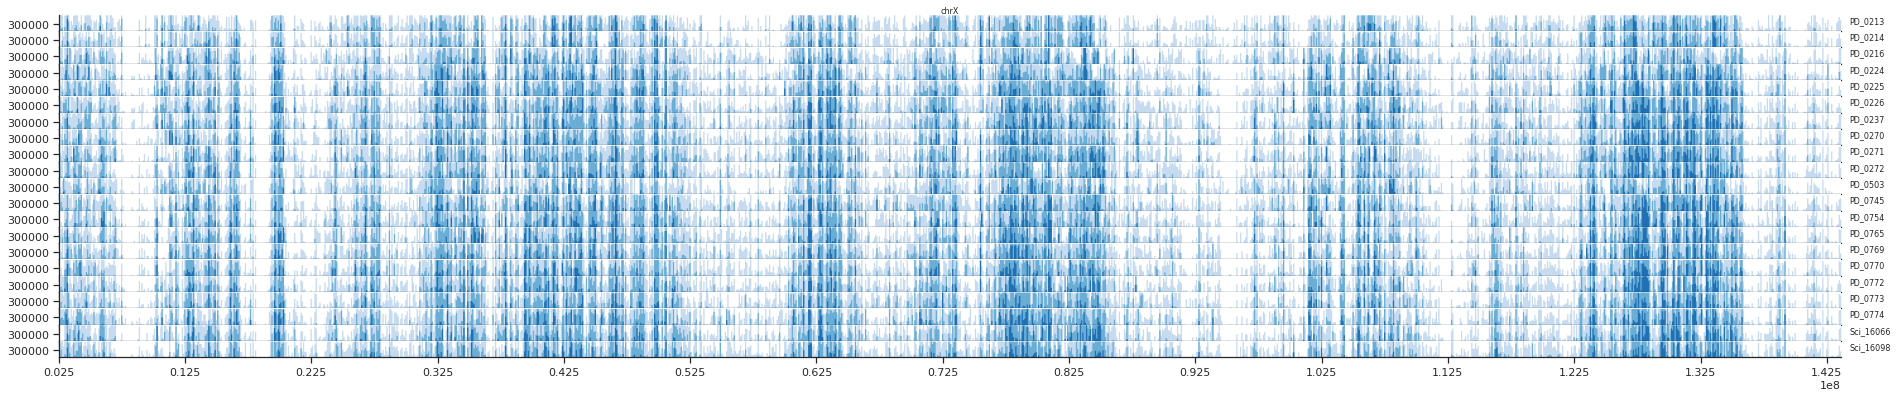

In [40]:
fig = horizonplot(ils_df, 'ils', width=2, col='chrom', row='PGDP_ID', size=0.3, aspect=100)